In [1]:
import anndata
import h5py
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
outpath = "/scratch/groups/horence/JuliaO/single_cell/spatial_kmers/notebooks/visium_meta/"

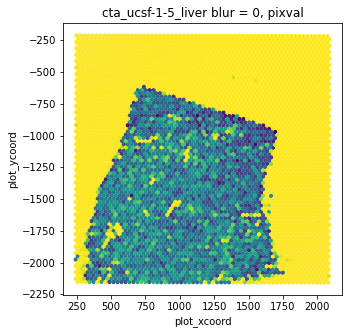

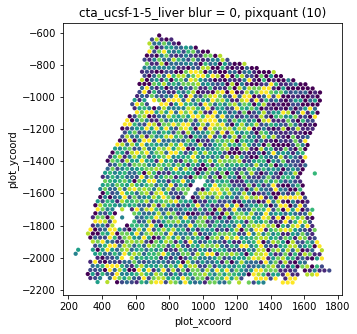

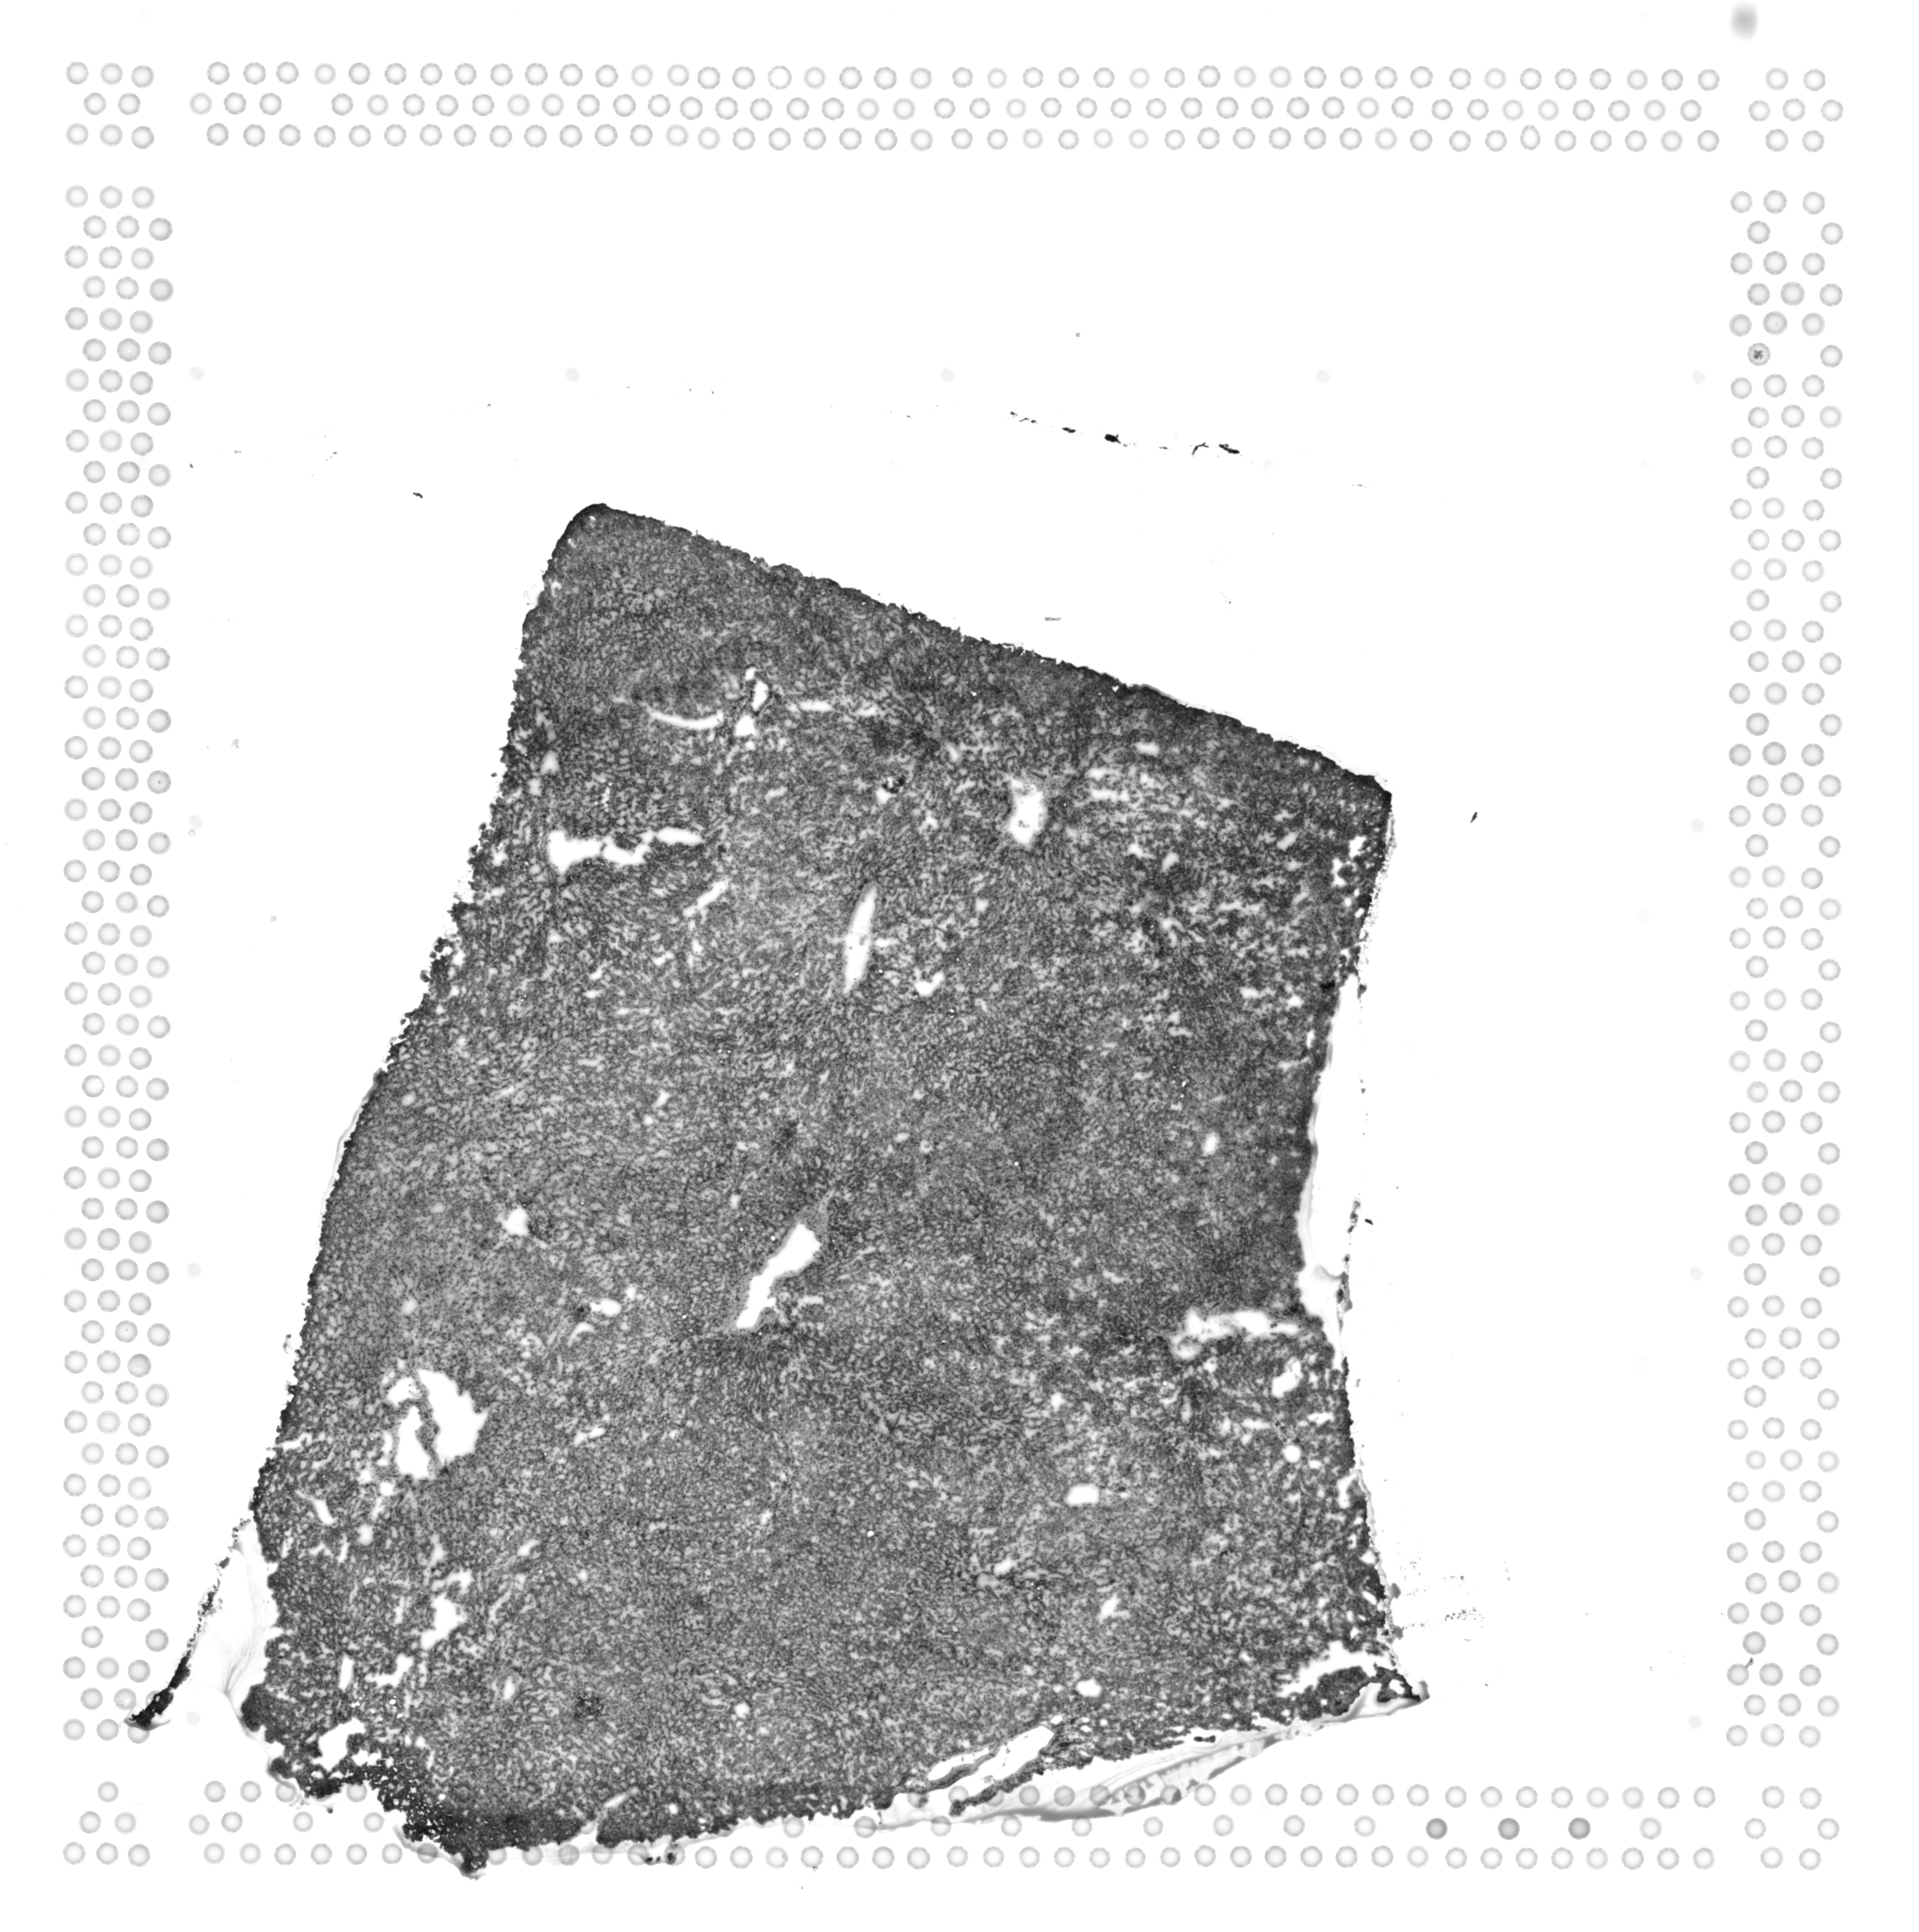

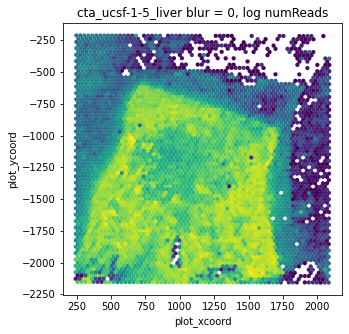

/scratch/groups/horence/JuliaO/single_cell/spatial_kmers/notebooks/visium_meta/meta_cta_ucsf-1-5_liver.tsv


In [6]:
# datanames = ["V1_Mouse_Brain_Sagittal_Anterior","V1_Mouse_Brain_Sagittal_Anterior_Section_2",
#             "V1_Mouse_Brain_Sagittal_Posterior","V1_Mouse_Brain_Sagittal_Posterior_Section_2",
#             "V1_Mouse_Kidney"]

datanames = ["cta_ucsf-1-5_liver"]
cer_loc_name = "/oak/stanford/groups/horence/JuliaO/data/visium/Biohub_covid_liver/cta_ucsf-1-5_liver/outs/spatial/tissue_positions_list.csv"
im_path = "/oak/stanford/groups/horence/JuliaO/data/visium/Biohub_covid_liver/cta_ucsf-1-5_liver_HE_4x_001.tif"
filt_bc_name = "/oak/stanford/groups/horence/JuliaO/data/visium/Biohub_covid_liver/cta_ucsf-1-5_liver/outs/filtered_feature_bc_matrix/barcodes.tsv.gz"
# datanames = ["V1_Mouse_Brain_Sagittal_Posterior"]

# dataname = "Visium_FFPE_Human_Breast_Cancer"
# datanames = ["Visium_FFPE_Human_Breast_Cancer","Visium_FFPE_Human_Normal_Prostate",
#             "Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma",
#             "Visium_FFPE_Human_Prostate_Cancer", "Visium_FFPE_Human_Prostate_IF",
#             "Visium_FFPE_Mouse_Brain_IF", "Visium_FFPE_Mouse_Brain",
#             "Visium_FFPE_Mouse_Kidney"]

# datanames = "["V1_Mouse_Brain_Sagittal_Posterior_Section_2",
#             ""V1_Mouse_Kidney"]

# datanames = ["p20190-s004_4_BrainMetastasis","p20218-s001_L1","p20218-s002_L2","p20218-s003_L3","p20218-s004_L4"]
# datanames = ["p20190-s003_3_BrainMetastasis"]


# patient_dict = {"p20190-s003_3_BrainMetastasis" : "pt15",
#                "p20190-s004_4_BrainMetastasis" : "pt19",
#                "p20218-s003_L3" : "pt24",
#                "p20218-s002_L2" : "pt27",
#                "p20218-s004_L4" : "pt16",
#                "p20218-s001_L1" : "pt26"}

Image.MAX_IMAGE_PIXELS = 692696316
bound = 5
rank_quant = "_r_0.01"
blurval = 0
q = 10
for dataname in datanames:
  
  # load in tissue positions list and image
  if dataname.startswith("V1"):
    cer_loc = pd.read_csv("/oak/stanford/groups/horence/JuliaO/data/visium/{}/spatial/tissue_positions_list.csv".format(dataname),names = ["barcode","in_tissue","array_row","array_col","xcoord","ycoord"])
    im_path = "/oak/stanford/groups/horence/JuliaO/data/visium/{}/{}_image.tif".format(dataname,dataname)
    filt_bc = pd.read_csv("/oak/stanford/groups/horence/JuliaO/data/visium/{}/filtered_feature_bc_matrix/barcodes.tsv.gz".format(dataname),names=["barcode"])

  elif dataname.startswith("p20"):
    cer_loc = pd.read_csv("/oak/stanford/groups/horence/JuliaO/data/visium/brain_metastases/{}/outs/spatial/tissue_positions_list.csv".format(dataname),names = ["barcode","in_tissue","array_row","array_col","xcoord","ycoord"])
    im_path = "/oak/stanford/groups/horence/JuliaO/data/visium/brain_metastases/all_spatial_images/{}.tif".format(patient_dict[dataname])
    filt_bc = pd.read_csv("/oak/stanford/groups/horence/JuliaO/data/visium/brain_metastases/{}/outs/filtered_feature_bc_matrix/barcodes.tsv.gz".format(dataname),names=["barcode"])
 
  else:
    cer_loc = pd.read_csv(cer_loc_name,names = ["barcode","in_tissue","array_row","array_col","xcoord","ycoord"])
    filt_bc = pd.read_csv(filt_bc_name,names=["barcode"])  
  cer_loc["cell_id"] = dataname + "_" + cer_loc["barcode"].str.split("_").str[0].str[:-2]
  
  # get coordinates that make image line up when plotted
  cer_loc["plot_xcoord"] = cer_loc["ycoord"]
  cer_loc["plot_ycoord"] = -cer_loc["xcoord"]
  
  # load image, convert to grayscale, and blur
  img = Image.open(im_path)
  img = img.convert('L')
  img = img.filter(ImageFilter.GaussianBlur(radius=blurval))
  blur = np.array(img)

  # get pixel values from the image
  cer_loc["pixval"] = -1
  for index, row in cer_loc.iterrows():
    cer_loc.loc[index,"pixval"] = blur[row["xcoord"],row["ycoord"]]
#     cer_loc.loc[index,"pixval"] = blur[row["ycoord"],row["xcoord"]]

  # plot raw pixvals
  plt.figure(figsize=(5,5))
  sns.scatterplot(data=cer_loc,x="plot_xcoord",y="plot_ycoord",hue="pixval",size=3,linewidth=0,palette="viridis",legend=False)
  plt.title("{} blur = {}, pixval".format(dataname,blurval))
  plt.savefig("{}{}_pixval.png".format(outpath,dataname))
  plt.show()
  
  try:
  #   spliz = pd.read_csv("/oak/stanford/groups/horence/JuliaO/nf-spliz-output/run_dir/visium/{}/SpliZ_values/{}_sym_SVD_normdonor_S_0.1_z_0.0_b_5_r_0.01_subcol.tsv".format(dataname,dataname),sep="\t")
    spliz = pd.read_parquet("/oak/stanford/groups/horence/JuliaO/nf-spliz-output/run_dir/visium/{}/SpliZ_values/{}_sym_SVD_normdonor_S_0.1_z_0.0_b_5_r_0.01.pq".format(dataname,dataname))
    spliz["reads_per_spot"] = spliz["cell"].map(spliz.groupby("cell")["numReads"].sum())
    spliz = spliz.drop_duplicates("cell")
    spliz["barcode"] = spliz["cell"].str.split("_").str[-1] + "-1"
    spliz["log_reads_per_spot"] = np.log(spliz["reads_per_spot"])
    set(spliz["barcode"])

    # filter to only include barcodes that are part of the tissue as determined by spaceranger
    cer_loc = cer_loc[cer_loc["barcode"].isin(set(filt_bc["barcode"]))]
    has_spliz = True
  #   cer_loc = cer_loc[cer_loc["barcode"].isin(set(spliz["barcode"]))]
  except Exception as e:
      print(e)
      has_spliz = False

  
  # quantile pixvals
  temp = cer_loc.drop_duplicates("barcode")[["barcode","pixval"]]
  
  # decrease the number of quantiles if necessary (all of the same value don't fit in a bin)
  qval = q
  while True:
    try:
      temp["pixquant"] = pd.qcut(temp['pixval'], qval, labels=False)
      break
    except:
      qval -= 1
      print(qval)
  temp.index = temp["barcode"]
  cer_loc["pixquant"] = cer_loc["barcode"].map(temp["pixquant"])
  
  # plot quantiled pixvals
  plt.figure(figsize=(5,5))
  sns.scatterplot(data=cer_loc,x="plot_xcoord",y="plot_ycoord",hue="pixquant",size=3,linewidth=0,palette="viridis",legend=False)
  plt.title("{} blur = {}, pixquant ({})".format(dataname,blurval,q))
  plt.savefig("{}{}_pixquant.png".format(outpath,dataname))

  plt.show()
  img.save("{}{}_blur.png".format(outpath,dataname))
  img.show()
  
  if has_spliz:
    if "xcoord" not in spliz.columns:
      spliz = spliz.merge(cer_loc[["cell_id","xcoord","ycoord"]],left_on = "cell",right_on="cell_id")
    
    # plot numreads
    plt.figure(figsize=(5,5))
    sns.scatterplot(data=spliz,x="plot_xcoord",y="plot_ycoord",hue="log_reads_per_spot",size=3,linewidth=0,palette="viridis",legend=False)
    plt.title("{} blur = {}, log numReads".format(dataname,blurval))
    plt.savefig("{}{}_log_numreads.png".format(outpath,dataname))

    plt.show()
    img.save("{}{}_blur.png".format(outpath,dataname))

  # save new file
  cer_loc.to_csv("{}meta_{}.tsv".format(outpath,dataname),sep="\t",index=False)
  print("{}meta_{}.tsv".format(outpath,dataname))

In [26]:
np.log(spliz["reads_per_spot"])

0         5.986452
1         7.319202
2         6.994850
3         6.923629
4         7.809541
            ...   
166364    1.791759
197763    1.945910
240467    1.945910
240600    2.197225
287030    1.945910
Name: reads_per_spot, Length: 4409, dtype: float64

In [20]:
spliz = spliz.merge(cer_loc[["cell_id","xcoord","ycoord"]],left_on = "cell",right_on="cell_id")

refName_newR1     gene  \
0       chr1:Col19a1:24319588:-|chr1:unknown:24615643:...  Col19a1   
1       chr1:Col19a1:24320898:-|chr1:unknown:24615643:...  Col19a1   
2       chr1:Col19a1:24349712:-|chr1:unknown:24613190:...  Col19a1   
3       chr1:Col19a1:24540859:-|chr1:unknown:24613187:...  Col19a1   
4         chr1:Cops9:92637403:-|chr1:Cops9:92639687:-|lin    Cops9   
...                                                   ...      ...   
302072  chr7:Rpl27a:109520642:+|chr7:Rpl27a:109521601:...   Rpl27a   
302073  chrY:Erdr1_1:90785979:+|chrY:Erdr1_1:90816349:...  Erdr1_1   
302074  chrY:Erdr1_1:90785979:+|chrY:Erdr1_1:90793296:...  Erdr1_1   
302075  chrY:Erdr1_1:90793417:+|chrY:Erdr1_1:90816349:...  Erdr1_1   
302076  chrY:Erdr1_1:90793680:+|chrY:Erdr1_1:90816349:...  Erdr1_1   

          juncStart      juncEnd chrR1A  numReads  \
0        24319588.0   24615643.0   chr1       1.0   
1        24320898.0   24615643.0   chr1       2.0   
2        24349712.0   24613190.0   chr1       1.0   
3        24540859.0   24613187.0   chr1       1.0   
4        92637403.0   92639687.0   chr1       4.0   
...             ...          ...    ...       ...   
302072  109520642.0  109521601.0   chr7       5.0   
302073   90785979.0   90816349.0   chrY       1.0   
302074   90785979.0   90793296.0   chrY       2.0   
302075   90793417.0   90816349.0   chrY       1.0   
302076   90793680.0   90816349.0   chrY       3.0   

                                                     cell             barcode  \
0       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...  GACCAAACGTTGACTG-1   
1       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...  GACCAAACGTTGACTG-1   
2       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...  GACCAAACGTTGACTG-1   
3       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...  GACCAAACGTTGACTG-1   
4       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...  GACCAAACGTTGACTG-1   
...                                                   ...                 ...   
302072  V1_Mouse_Brain_Sagittal_Posterior_TCTTACAGAGGT...  TCTTACAGAGGTACCG-1   
302073  V1_Mouse_Brain_Sagittal_Posterior_CGTGCAGACTGG...  CGTGCAGACTGGGACA-1   
302074  V1_Mouse_Brain_Sagittal_Posterior_CGTGCAGACTGG...  CGTGCAGACTGGGACA-1   
302075  V1_Mouse_Brain_Sagittal_Posterior_CGTGCAGACTGG...  CGTGCAGACTGGGACA-1   
302076  V1_Mouse_Brain_Sagittal_Posterior_CGTGCAGACTGG...  CGTGCAGACTGGGACA-1   

        in_tissue  array_row  ...    svd_z0        f1    svd_z1        f2  \
0             1.0       58.0  ... -1.098941  0.099500  1.065345  0.086101   
1             1.0       58.0  ... -1.098941  0.099500  1.065345  0.086101   
2             1.0       58.0  ... -1.098941  0.099500  1.065345  0.086101   
3             1.0       58.0  ... -1.098941  0.099500  1.065345  0.086101   
4             1.0       58.0  ... -0.221638  0.168160 -0.055307  0.140375   
...           ...        ...  ...       ...       ...       ...       ...   
302072        1.0       15.0  ...  0.025664  0.223473  0.157314  0.168091   
302073        1.0       40.0  ... -0.096842  0.280532 -0.007421  0.100488   
302074        1.0       40.0  ... -0.096842  0.280532 -0.007421  0.100488   
302075        1.0       40.0  ... -0.096842  0.280532 -0.007421  0.100488   
302076        1.0       40.0  ... -0.096842  0.280532 -0.007421  0.100488   

          svd_z2  svd_z_sumsq  reads_per_spot  \
0       0.713398     2.851568           398.0   
1       0.713398     2.851568           398.0   
2       0.713398     2.851568           398.0   
3       0.713398     2.851568           398.0   
4       0.788201     0.673443           398.0   
...          ...          ...             ...   
302072 -0.232628     0.079522            15.0   
302073 -0.032950     0.010519             7.0   
302074 -0.032950     0.010519             7.0   
302075 -0.032950     0.010519             7.0   
302076 -0.032950     0.010519             7.0   

                                                  cell_id  xcoord_y  ycoord_y  

In [22]:
spliz["xcoord"]

0         8368.0
1         8487.0
2         8368.0
3         5133.0
4         8368.0
           ...  
318089    8847.0
318090    9446.0
318091    3815.0
318092    2736.0
318093    9086.0
Name: xcoord, Length: 318094, dtype: float64

In [32]:
while True:
  qval = q
  try:
    pd.qcut(temp['pixval'], qval, labels=False)
    break
  except:
    q -= 1
    print(q)


9
8
7


In [7]:
filt_bc = pd.read_csv("/oak/stanford/groups/horence/JuliaO/data/visium/{}/filtered_feature_bc_matrix/barcodes.tsv.gz".format(dataname),names=["barcodes"])

In [10]:
filt_bc

barcodes
0     AAACAAGTATCTCCCA-1
1     AAACACCAATAACTGC-1
2     AAACAGAGCGACTCCT-1
3     AAACAGCTTTCAGAAG-1
4     AAACAGGGTCTATATT-1
...                  ...
3350  TTGTTCAGTGTGCTAC-1
3351  TTGTTGTGTGTCAAGA-1
3352  TTGTTTCACATCCAGG-1
3353  TTGTTTCATTAGTCTA-1
3354  TTGTTTCCATACAACT-1

[3355 rows x 1 columns]

In [36]:
cer_loc

barcode  in_tissue  array_row  array_col  xcoord  ycoord  \
0     ACGCCTGACACGCGCT-1          0          0          0    3586    5281   
1     TACCGATCCAACACTT-1          0          1          1    3839    5425   
2     ATTAAAGCGGACGAGC-1          0          0          2    3587    5571   
3     GATAAGGGACGATTAG-1          0          1          3    3839    5716   
4     GTGCAAATCACCAATA-1          0          0          4    3587    5861   
...                  ...        ...        ...        ...     ...     ...   
4987  GAACGTTTGTATCCAC-1          0         77        123   23064   23092   
4988  ATTGAATTCCCTGTAG-1          0         76        124   22812   23237   
4989  TACCTCACCAATTGTA-1          0         77        125   23065   23382   
4990  AGTCGAATTAGCGTAA-1          0         76        126   22813   23527   
4991  TTGAAGTGCATCTACA-1          0         77        127   23065   23672   

                                        cell_id  clust_3  
0     Visium_FFPE_Mouse_Kidney_ACGCCTGACACGCGCT        0  
1     Visium_FFPE_Mouse_Kidney_TACCGATCCAACACTT        0  
2     Visium_FFPE_Mouse_Kidney_ATTAAAGCGGACGAGC        0  
3     Visium_FFPE_Mouse_Kidney_GATAAGGGACGATTAG        0  
4     Visium_FFPE_Mouse_Kidney_GTGCAAATCACCAATA        0  
...                                         ...      ...  
4987  Visium_FFPE_Mouse_Kidney_GAACGTTTGTATCCAC        2  
4988  Visium_FFPE_Mouse_Kidney_ATTGAATTCCCTGTAG        2  
4989  Visium_FFPE_Mouse_Kidney_TACCTCACCAATTGTA        2  
4990  Visium_FFPE_Mouse_Kidney_AGTCGAATTAGCGTAA        2  
4991  Visium_FFPE_Mouse_Kidney_TTGAAGTGCATCTACA        2  

[4992 rows x 8 columns]

In [11]:
dataname = "Visium_FFPE_Human_Breast_Cancer"
adata = sc.datasets.visium_sge(sample_id=dataname)
df = pd.DataFrame(adata.obsm["spatial"],index=adata.obs_names)
df.rename(columns={0: "xcoord",1 : "ycoord"},inplace=True)
df["cell_id"] = dataname + "_" + df.index.str[:-2]
num_clust = 3
kmeans = KMeans(n_clusters=num_clust, random_state=0).fit(df[["xcoord","ycoord"]])
df["clust_" + str(num_clust)] = kmeans.labels_
sns.scatterplot(data = df, x="xcoord", y = "ycoord",hue="clust_{}".format(num_clust),alpha = 0.1)


HTTPError: HTTP Error 403: Forbidden

In [13]:
df.to_csv("{}meta_{}.tsv".format(outpath,dataname),sep="\t",index=False)

In [7]:

df.iloc[0]["cell_id"]

'V1_Mouse_Brain_Sagittal_Anterior_AAACAAGTATCTCCCA'

In [73]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3



The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                 8.3.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.14.6
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           5.0.9
h5py                3.3.0
ipykernel           6.2.0
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
llvmlite            0.38.0
matplotlib  

In [74]:
adata = sc.datasets.visium_sge(sample_id="Visium_FFPE_Mouse_Brain")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)


100%|██████████| 7.86M/7.86M [00:00<00:00, 71.8MB/s]
100%|██████████| 29.3M/29.3M [00:00<00:00, 79.8MB/s]

reading /scratch/groups/horence/JuliaO/single_cell/spatial_kmers/notebooks/data/V1_Human_Lymph_Node/filtered_feature_bc_matrix.h5



Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


100%|██████████| 8.81M/8.81M [00:00<00:00, 52.2MB/s]
100%|██████████| 19.6M/19.6M [00:00<00:00, 23.0MB/s]
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
adata.obsm["spatial"]

array([[17428, 15937],
       [ 6092, 18054],
       [16351,  7383],
       ...,
       [ 7593, 18294],
       [ 7190, 14730],
       [10484,  5709]])

In [96]:
adata.obsm["spatial"][:,1]

array([6982, 1363, 2672, ..., 6396, 9747, 1840])

In [12]:
pd.DataFrame(adata.obsm["spatial"],index=adata.obs_names)

0     1
AAACAAGTATCTCCCA-1  8500  7474
AAACACCAATAACTGC-1  2788  8552
AAACAGAGCGACTCCT-1  7950  3163
AAACAGCTTTCAGAAG-1  2100  6636
AAACAGGGTCTATATT-1  2375  7115
...                  ...   ...
TTGTGTTTCCCGAAAG-1  5541  7594
TTGTTCAGTGTGCTAC-1  5885  4361
TTGTTGTGTGTCAAGA-1  6780  5199
TTGTTTCACATCCAGG-1  4371  8433
TTGTTTCCATACAACT-1  3339  6876

[2695 rows x 2 columns]

In [100]:
len("AAACAAGTATCTCCCA")

16

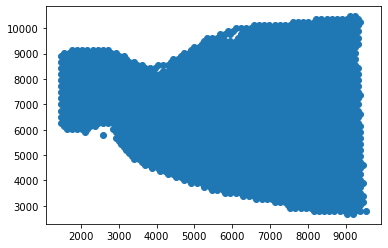

In [11]:
plt.plot(adata.obsm["spatial"][:,0],adata.obsm["spatial"][:,1],marker="o",linestyle="")
plt.show()

In [90]:
adata.obs_names

Index(['AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1', 'AAACAGAGCGACTCCT-1',
       'AAACAGCTTTCAGAAG-1', 'AAACAGGGTCTATATT-1', 'AAACAGTGTTCCTGGG-1',
       'AAACATTTCCCGGATT-1', 'AAACCGGGTAGGTACC-1', 'AAACCGTTCGTCCAGG-1',
       'AAACCTAAGCAGCCGG-1',
       ...
       'TTGTGTTTCCCGAAAG-1', 'TTGTTAGCAAATTCGA-1', 'TTGTTCAGTGTGCTAC-1',
       'TTGTTGGCAATGACTG-1', 'TTGTTGTGTGTCAAGA-1', 'TTGTTTCACATCCAGG-1',
       'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1', 'TTGTTTGTATTACACG-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=3861)

/home/users/jolivier/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/users/jolivier/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


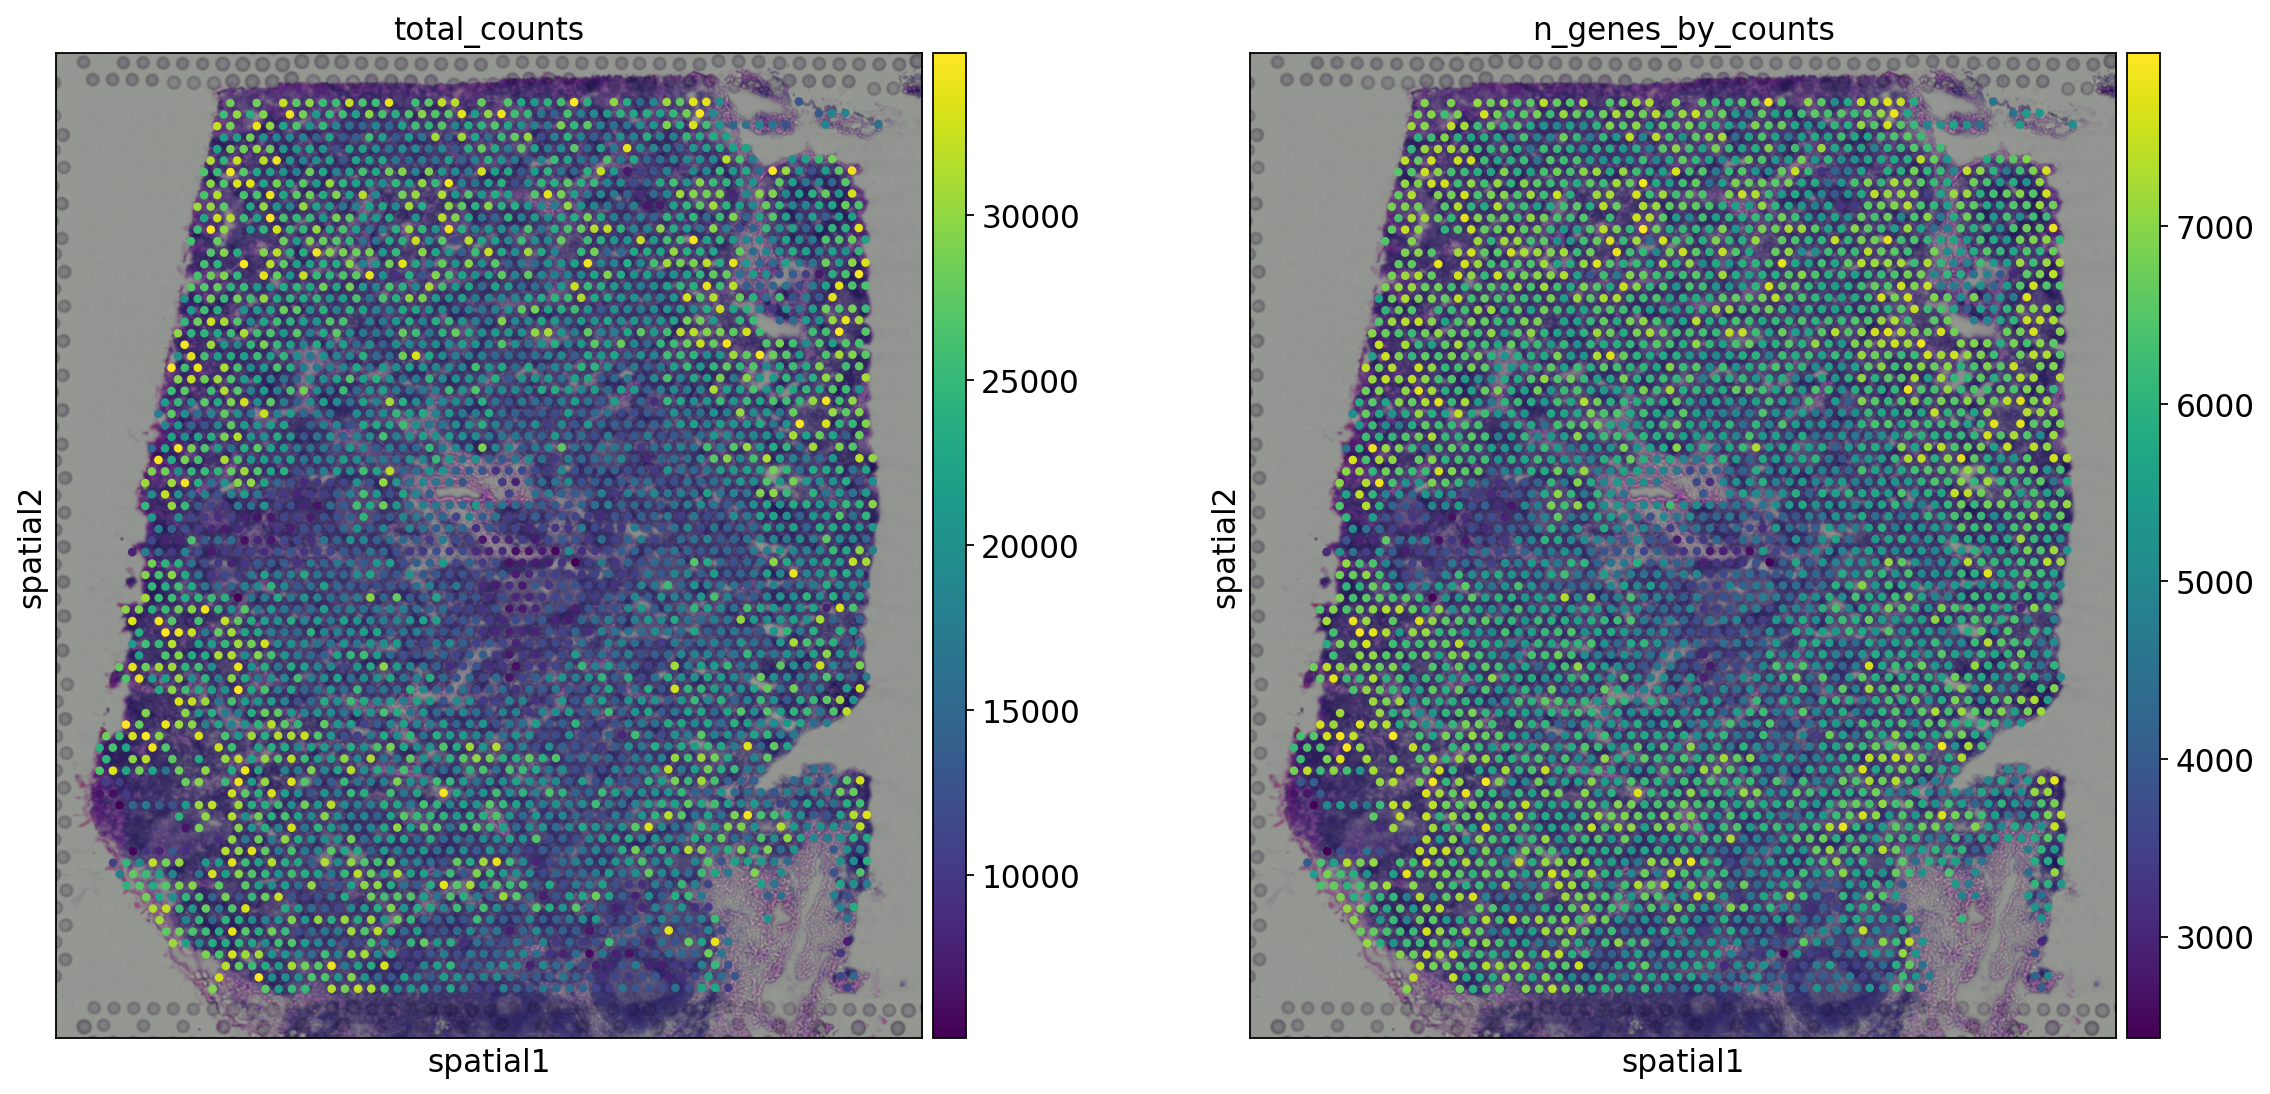

In [81]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

In [ ]:
fn = "/oak/stanford/groups/horence/JuliaO/data/visium/V1_Mouse_Brain_Sagittal_Anterior/V1_Mouse_Brain_Sagittal_Anterior_molecule_info.h5"
with h5py.File(fn,"r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])

Keys: <KeysViewHDF5 ['barcode_idx', 'barcode_info', 'barcodes', 'count', 'feature_idx', 'features', 'gem_group', 'library_idx', 'library_info', 'metrics_json', 'umi']>


In [ ]:
ann = anndata.read("/oak/stanford/groups/horence/JuliaO/data/visium/V1_Mouse_Brain_Sagittal_Anterior/V1_Mouse_Brain_Sagittal_Anterior_molecule_info.h5")

In [67]:
ann.uns

OverloadedDict, wrapping:
	OrderedDict()
With overloaded keys:
	['neighbors'].

In [16]:
f = h5py.File(fn, 'r')

In [59]:
for x in f.attrs:
  print(x)

file_version
filetype


<HDF5 dataset "metrics_json": shape (), type "|O">

In [3]:
df = pd.read_parquet("/oak/stanford/groups/horence/JuliaO/nf-spliz-output/run_dir/SlideSeq/Puck_180430_5/class_input/Puck_180430_5.pq")

In [7]:
df[df["geneR1A_uniq"] == "Myl6"].groupby("refName_newR1")["numReads"].sum().sort_values()

refName_newR1
chr10:Myl6:128490886:-|chr10:Myl6:128492716:-|lin          1
chr10:Myl6:128493353:-|chr10:Myl6:128493539:-|lin          1
chr10:Myl6:128493045:-|chr10:Myl6:128493334:-|lin          1
chr10:Myl6:128492745:-|chr10:Myl6:128493535:-|lin          1
chr10:Myl6:128492402:-|chr10:Myl6:128492710:-|lin          1
chr10:Myl6:128492339:-|chr10:Myl6:128492436:-|lin          1
chr10:Myl6:128492136:-|chr10:Myl6:128492223:-|lin          1
chr10:Myl6:128493857:-|chr10:Rab5b:128690838:-|lin         1
chr10:Myl6:128490927:-|chr10:Myl6:128490979:-|lin          1
chr10:Myl6:128491033:-|chr10:Myl6:128491286:-|lin          1
chr10:Myl6:128490930:-|chr10:Myl6:128492395:-|lin          1
chr10:Myl6:128491347:-|chr10:Myl6:128491720:-|lin          2
chr10:Myl6:128492381:-|chr10:Myl6:128493874:-|lin          2
chr10:Myl6:128493566:-|chr10:unknown:128494000:?|lin       2
chr10:Myl6:128492402:-|chr10:Myl6:128493539:-|lin          3
chr10:Myl6:128492502:-|chr10:Myl6:128492602:-|lin          3
chr10:Myl6

In [8]:
df2 = pd.read_parquet("/scratch/groups/horence/JuliaO/single_cell/SZS_pipeline2/data/Tabula_muris_senis_P2_10x_with_postprocessing_cellann.pq")

In [9]:
df2[df2["geneR1A_uniq"] == "Myl6"].groupby("refName_newR1")["numReads"].sum().sort_values()

refName_newR1
chr10:Myl6:128493539:-|chr10:Myl6:128492535:-|lin        1
chr10:Myl6:128492693:-|chr10:Myl6:128492355:-|lin        1
chr10:Myl6:128492083:-|chr10:Myl6:128490999:-|lin        1
chr10:Myl6:128492602:-|chr10:Myl6:128492136:-|lin        1
chr10:Myl6:128492114:-|chr10:Myl6:128491031:-|lin        2
chr10:Myl6:128491720:-|chr10:Myl6:128491031:-|lin        2
chr10:Myl6:128492939:-|chr10:Myl6:128492745:-|lin        2
chr10:Myl6:128491720:-|chr10:Myl6:128491347:-|lin        3
chr10:Myl6:128492077:-|chr10:Myl6:128491033:-|lin        3
chr10:Myl6:128492602:-|chr10:Myl6:128492502:-|lin        4
chr10:Myl6:128492602:-|chr10:Myl6:128492352:-|lin        4
chr10:Myl6:128491286:-|chr10:Myl6:128491033:-|lin        5
chr10:Myl6:128493539:-|chr10:Myl6:128492745:-|lin      172
chr10:Myl6:128492059:-|chr10:Myl6:128491347:-|lin      175
chr10:Myl6:128491290:-|chr10:Myl6:128491033:-|lin      177
chr10:Myl6:128493809:-|chr10:Myl6:128493566:-|lin      263
chr10:Myl6:128492059:-|chr10:Myl6:12849176